# Review


In [ ]:
import tensorflow as tf
from tensorflow.keras.datasets import mnist

(x_train_arr, y_train_arr), (x_test_arr, y_test_arr) = mnist.load_data()
x_train, x_test, y_train, y_test = tf.convert_to_tensor(x_train_arr), tf.convert_to_tensor(x_test_arr), tf.convert_to_tensor(y_train_arr), tf.convert_to_tensor(y_test_arr)


2024-11-25 08:57:43.896060: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1732553863.908332   13897 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1732553863.912065   13897 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-25 08:57:43.924286: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


It's time for us to start our journey into prediction. We're going to start with a very basic model 1-nn. We expect this to have perfect accuracy on the training data.

In [107]:
def unit_vectorize_input(input):
    vectors =  tf.reshape(tf.cast(input, tf.float32), [tf.shape(input)[0], -1])
    unit_vectors = tf.linalg.l2_normalize(vectors, axis=1)
    return unit_vectors

def nearest_neighbor_model(input):
    cosine_sim = tf.matmul(unit_vectorize_input(input), unit_vectorize_input(x_train), transpose_b=True)
    y_train_indices = tf.argmax(cosine_sim, axis=1)
    prediction = tf.gather(y_train, y_train_indices)
    return tf.one_hot(prediction, depth=10)

nearest_neighbor_model(x_train[:1000])

<tf.Tensor: shape=(1000, 10), dtype=float32, numpy=
array([[0., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)>

We're going to compare this to a naive model that gives every class an equal probability.

In [108]:
import tensorflow as tf

# Define the uniform model
num_classes = 10  
uniform_model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(28,28)),  # Placeholder input, adjust as needed
    tf.keras.layers.Lambda(lambda x: tf.fill((tf.shape(x)[0], num_classes), 1.0 / num_classes))
])

As expected this outputs a prediction vector where every class has an equal probability.

## Evaluating our First Models

Now let's score both models on 100 samples. We're going to do something bad and evaluate the models on the training data. This is just to introduce some of the ideas of evaluation. Later we will evaluate them on test data instead.

In [131]:
x_sample = x_train[:100]
y_sample = y_train[:100]


pred_uniform = uniform_model(x_sample)
pred_nn = nearest_neighbor_model(x_sample)

We expect `nearest_neighbor_model` to perform much better than `uniform_model` on the training data. 

Why is this? 
- We expect the `nearest_neighbor_model` will always give the correct class a probability of `1`. 
- We expect `uniform_model` will always give the correct class a probability of `1/10`. Let's double check this assumption.

Let's verify this assumption before continuing.

We can multiply the predictions by the output vector to get a better idea of what's going on. 

In [127]:
tf.one_hot(y_sample, 10) * pred_uniform

<tf.Tensor: shape=(100, 10), dtype=float32, numpy=
array([[0. , 0. , 0. , 0. , 0. , 0.1, 0. , 0. , 0. , 0. ],
       [0.1, 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ],
       [0. , 0. , 0. , 0. , 0.1, 0. , 0. , 0. , 0. , 0. ],
       [0. , 0.1, 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ],
       [0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0.1],
       [0. , 0. , 0.1, 0. , 0. , 0. , 0. , 0. , 0. , 0. ],
       [0. , 0.1, 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ],
       [0. , 0. , 0. , 0.1, 0. , 0. , 0. , 0. , 0. , 0. ],
       [0. , 0.1, 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ],
       [0. , 0. , 0. , 0. , 0.1, 0. , 0. , 0. , 0. , 0. ],
       [0. , 0. , 0. , 0.1, 0. , 0. , 0. , 0. , 0. , 0. ],
       [0. , 0. , 0. , 0. , 0. , 0.1, 0. , 0. , 0. , 0. ],
       [0. , 0. , 0. , 0.1, 0. , 0. , 0. , 0. , 0. , 0. ],
       [0. , 0. , 0. , 0. , 0. , 0. , 0.1, 0. , 0. , 0. ],
       [0. , 0.1, 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ],
       [0. , 0. , 0. , 0. , 0. , 0. , 0. , 0.1, 0. , 0. ],
     

If we ignore the zeros, we can see that this model always outputs a .1 for the correct class. 

Instead of ignoring the zeros, let's just sum across the second index to remove them.

In [133]:
tf.reduce_sum(tf.one_hot(y_sample, 10) * pred_uniform, axis=1)

<tf.Tensor: shape=(100,), dtype=float32, numpy=
array([0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1,
       0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1,
       0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1,
       0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1,
       0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1,
       0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1,
       0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1,
       0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1], dtype=float32)>

Ah ha! Just as we predicted the uniform class always outputs a `1/10` probability for the correct class. 

Let's now test our same assumption with `nearest_neighbor_model`


In [134]:
tf.reduce_sum(tf.one_hot(y_sample, 10) * pred_nn, axis=1)

<tf.Tensor: shape=(100,), dtype=float32, numpy=
array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
      dtype=float32)>

We see that the nearest neighbor model gives the correct class a higher probability than the uniform and so on the training data it performs better. 

Let's make this finding a bit more concise.



In [ ]:
mean_prob_for_uniform = tf.reduce_mean(tf.reduce_sum(tf.one_hot(y_sample, 10) * pred_uniform, axis=1))
mean_prob_for_nn = tf.reduce_mean(tf.reduce_sum(tf.one_hot(y_sample, 10) * pred_nn, axis=1))

print("Mean probability for uniform model: ", mean_prob_for_uniform.numpy())
print("Mean probability for nearest neighbor model: ", mean_prob_for_nn.numpy())

Mean probability for uniform model:  0.1
Mean probability for nearest neighbor model:  1.0


## Mean Probability Loss

We're going to call our fancy new model scorer **mean probability loss**. We are going to see that there are a few problems with this loss function though. Let's give it a spin in some novel situations and see what it does for us.

Let's say we have an unfair coin that flips heads 70% of the time. Let's see if our *mean probability loss* can help us find the unfairness of the coin after observing 1000 flips.

In [266]:
# define a random tensor where there is a 70% chance of a 1 and 30% chance of a 0

sample_size =10000
random_tensor = tf.random.uniform([sample_size, ], minval=0, maxval=1)
binary_tensor = tf.cast(random_tensor > 0.2, tf.int32)
flips = tf.one_hot(binary_tensor, 2)
# sum up each row of the one hot tensor
tf.reduce_mean(flips, axis=0)



<tf.Tensor: shape=(2,), dtype=float32, numpy=array([0.1952, 0.8048], dtype=float32)>

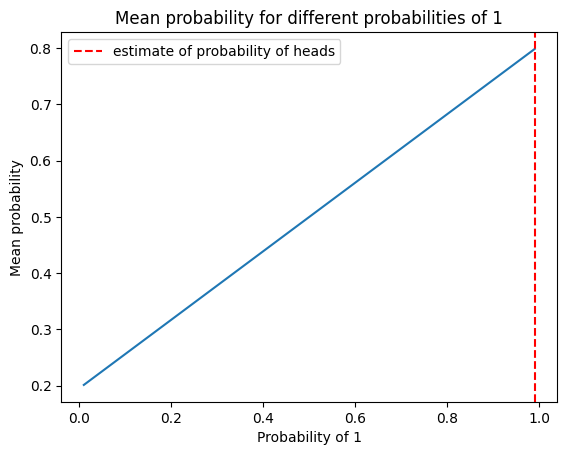

In [275]:
import numpy as np
import matplotlib.pyplot as plt
from math import log
# Dummy one_hot_tensor for demonstration purposes; replace with your actual tensor

def get_mean_prob(x):
    predictions =  tf.constant([[(1-x), (x)]] * sample_size, dtype=tf.float32)
    
    return tf.reduce_mean(tf.reduce_sum(flips * predictions, axis=1)).numpy()

x_values = np.linspace(0.01, 0.99, 100)  # Use numpy linspace for easier iteration
y_values = [get_mean_prob(float(i)) for i in x_values]
y_star = max(y_values) 
x_star = x_values[y_values.index(y_star)]
plt.plot(x_values, y_values)
plt.axvline(x=x_star, color='r', linestyle='--', label='estimate of probability of heads')
# label needs to show up
plt.legend()
plt.xlabel('Probability of 1')
plt.ylabel('Mean probability')
plt.title('Mean probability for different probabilities of 1')

plt.show()


**Something is wrong**

Something is wrong here. We are trying to use our new *mean probability* metric to infer the likelihood of a heads. We expect that the higher this metric is, the better the model. But the 'best' model according to mean probability is giving 100% likleyhood to 1, even though we *know* the best model should give 80% to 1. 

**What is going wrong**

Apparently *mean probability* prefers a confident model that always predicts heads. Let's comapre this confident model, with the model we *know is correct*.

In [322]:
from dlib.helper import printmd

predictions_correct = tf.constant([[.2, .8]] * sample_size, dtype=tf.float32)
predictions_confident = tf.constant([[0, 1]] * sample_size, dtype=tf.float32)

models = {
    "predictions_correct": predictions_correct,
    "predictions_confident": predictions_confident
}

for model in ["predictions_correct", "predictions_confident"]:
    predictions = models[model]
    dot = tf.reduce_sum(flips * predictions, axis=1)
    mean_prob = tf.reduce_mean(dot).numpy()
    printmd(f"**{model} model** \n  - Mean probability: {mean_prob:.2f} \n - probability of right answer \n {dot} \n ")



**predictions_correct model** 
  - Mean probability: 0.68 
 - probability of right answer 
 [0.8 0.8 0.8 ... 0.8 0.2 0.8] 
 

**predictions_confident model** 
  - Mean probability: 0.80 
 - probability of right answer 
 [1. 1. 1. ... 1. 0. 1.] 
 

The confident model decides to put all of it's probability on heads. It assigns 0 probability to tails. When a heads is called, it looks prophetic, when a tail gets called it gets penalized, but that doesn't happen very often. Apparently with **mean probability**, it pays to be cocky.

There is not justice here. The confident model get's all the rewards while our correct model meekly eeks by. We need justice. Which means we need to move beyond *mean probability*.

**Moving beyond mean probability**

The problem is that we aren't punishing the confident model enough for unlikely events. If a model predicts a 1, we want a penalty function that looks like one of these: 




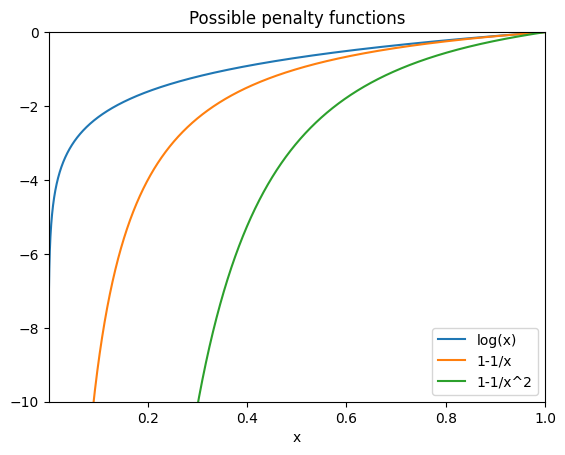

In [348]:
#Make a graph of a log, and of 1/x with matplot lib where the values range from 0 to 1 with a linspace

x_values = np.linspace(0.000001, 1, 10000)  # Use numpy linspace for easier iteration
log_values = [log(i) for i in x_values]
inverse_values = [1-1/i for i in x_values]
sq_inverse_values = [1-1/(i*i) for i in x_values]

plt.plot(x_values, log_values, label='log(x)')
plt.plot(x_values, inverse_values, label='1-1/x')
plt.plot(x_values, sq_inverse_values, label='1-1/x^2')
plt.xlabel('x')
# plt should show values from -10 to 0
plt.ylim(-10, 0)
plt.xlim(0.001, 1)
plt.legend()
plt.title('Possible penalty functions')

plt.show()


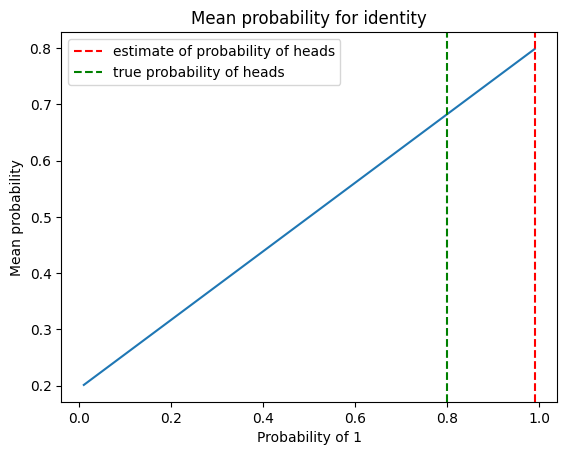

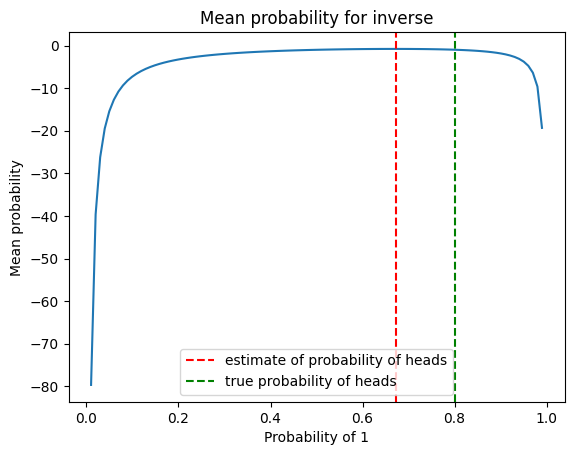

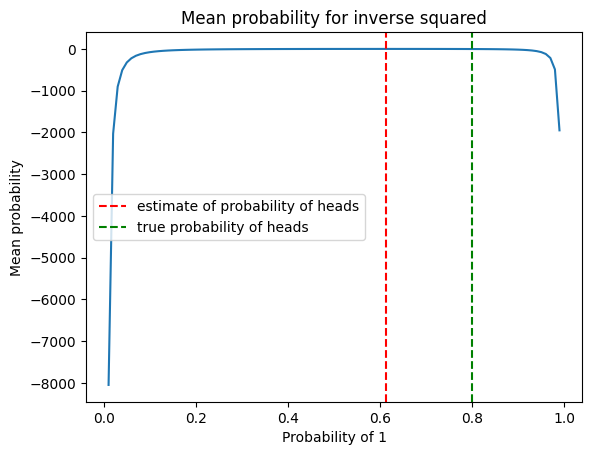

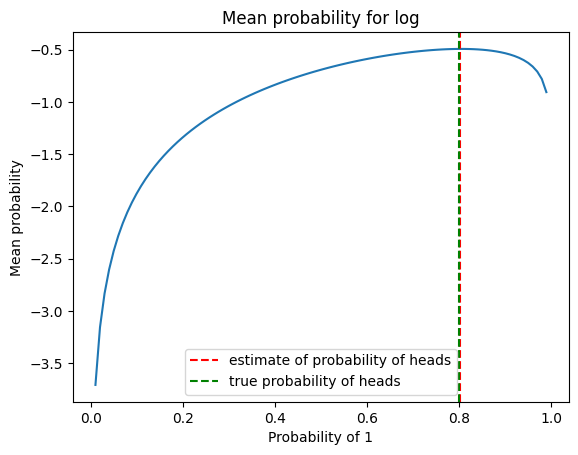

In [349]:
def find_coin_flip_probability(penalty, penalty_name):
    def get_mean_prob(x):
        predictions =  tf.constant([[(1-x), (x)]] * sample_size, dtype=tf.float32)
        
        return tf.reduce_mean(tf.reduce_sum(flips * penalty(predictions), axis=1)).numpy()

    x_values = np.linspace(0.01, 0.99, 100)  # Use numpy linspace for easier iteration
    y_values = [get_mean_prob(float(i)) for i in x_values]
    y_star = max(y_values) 
    x_star = x_values[y_values.index(y_star)]
    plt.plot(x_values, y_values)
    plt.axvline(x=x_star, color='r', linestyle='--', label='estimate of probability of heads')
    plt.axvline(x=0.8, color='g', linestyle='--', label='true probability of heads')
    # label needs to show up
    plt.legend()
    plt.xlabel('Probability of 1')
    plt.ylabel('Mean probability')
    plt.title(f'Mean probability for {penalty_name}')

    plt.show()

penalties = [
    (lambda x: x, "identity"),
    (lambda x: 1-1/x, "inverse"),
    (lambda x: 1-1/(x*x), "inverse squared"),
    (tf.math.log, "log"),
]

for penalty, penalty_name in penalties:
    find_coin_flip_probability(penalty, penalty_name)

Wow, there is something very special about modifying our **mean probability** using logs.

In [34]:
model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(28, 28)),
    tf.keras.layers.Dense(10, activation='softmax')
])

/home/jackson/code/dl/venv/lib/python3.10/site-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [35]:
scce = tf.keras.losses.SparseCategoricalCrossentropy()

pred_train = model(x_train)

loss = scce(y_train, pred_train)

print(loss)

tf.Tensor(179.74203, shape=(), dtype=float32)


I'm a little surprised the sparse entropy loss is so high. I would expect it to be around 2.3 like the uniform model.

Let's calculate this ourselves to see what's going on.


In [58]:
# cross_entropy = -tf.reduce_sum(tf.one_hot(y_train, depth=10) * tf.math.log(pred_train + 1e-30), axis=1)  # Avoid log(0) with small epsilon

 
tf.math.log(pred_train) * tf.one_hot(y_train, depth=10)

<tf.Tensor: shape=(60000, 10), dtype=float32, numpy=
array([[      nan,       nan,       nan, ...,  -0.     ,       nan,
              nan],
       [     -inf,       nan,  -0.     , ...,  -0.     ,  -0.     ,
          0.     ],
       [ -0.     ,       nan,  -0.     , ...,       nan,       nan,
         -0.     ],
       ...,
       [      nan,       nan,  -0.     , ...,  -0.     ,       nan,
              nan],
       [      nan,       nan,       nan, ...,       nan,       nan,
              nan],
       [ -0.     ,       nan,  -0.     , ...,  -0.     , -58.72172,
         -0.     ]], dtype=float32)>

In [66]:
from math import log, log10

-log(1/10)

2.3025850929940455

In [16]:
with tf.GradientTape() as tape:
    pred_train = model(x_train)

    loss = scce(y_train, pred_train)

gradients = tape.gradient(loss, model.trainable_variables)


Reshaped gradient shape: (28, 28, 10)


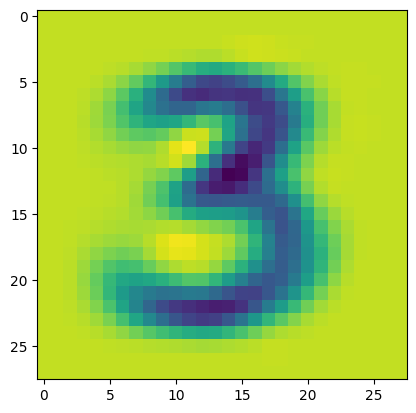

In [42]:
# let's look at gradients



from matplotlib import pyplot as plt

reshaped_gradient = tf.reshape(gradients[0], (28, 28, 10))
print("Reshaped gradient shape:", reshaped_gradient.shape)

plt.imshow(reshaped_gradient[:,:, 3])